# Predictive model and feature importance for state level homelessness

*CS109A/AC209A Group 8 final project*

**Contact info:** Renhao Luo (renhao_luo@hms.harvard.edu), Ziqi Wang (ziqiwang@hms.harvard.edu), Shun Li (shunli@g.harvard.edu), Linzi Yu (linzi_yu@hms.harvard.edu), Senmiao Sun (sun_senmiao@g.harvard.edu)

<hr style="height:2pt">

In [8]:
# Install dependencies
# !pip install plotly
# !pip install missingno
# !pip install hyperopt
# !pip install xgboost
# !conda install -c conda-forge shap -y

In [9]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import missingno as mn
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DataConversionWarning)

<a id='toc1_'></a>

## Introduction

By recent estimates, over 600,000 Americans live in some state of homelessness each year. In recent decades, the quality of available data on homelessness in the United States has greatly improved, but there is still a long way to go. 

In this project, we combined different state-level statistics (housing, income, and political involvement) that are related to homelessness, and build multiple regression models for predicting the number homeless people in the United States. In addition, we discussed about the most important predictors for the machine learning models. In a word, we aim to enhance our understanding of the causes of homelessness from different perspectives by interpreting the most important features highlighted by the machine learning models.

The state level homeless data we used were from Kaggle (https://www.kaggle.com/code/adamschroeder/homelessness-comparison-between-states/data), which contains the data collected by the US Department of Housing and Urban Development (HUD). 

For model prediction, we also included features from these datasets:
- Zillow Housing Data: https://www.kaggle.com/datasets/zillow/zecon
- US Economics Profile by county: https://www.kaggle.com/datasets/davidbroberts/us-economic-profile-by-county?resource=download&select=profile_by_county_1969_2019.csv
- County Presidential Election Returns 2000-2020: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ






**Table of contents**<a id='contents'></a>    
- [**Introduction**](#toc1_)
- [**Data Preprocessing and Exploratory Data Analysis (EDA)**](#toc2_)    
  - [Homeless data preprocess](#toc2_1_)    
  - [Housing data preprocess](#toc2_2_)
  - [Politics data preprocess](#toc2_3_)    
  - [Economic profile data preprocess](#toc2_4_)    
  - [Merge datasets](#toc2_5_)    
  - [Missing values](#toc2_6_)    
  - [Correlation between each variable and homeless count](#toc2_7_)
  - [Combined data preprocess: categorical variable, impute missing data, feature scaling](#toc2_8_)
- [**Regression Modeling and Evaluation**](#toc3_)    
  - [1. Baseline model](#toc3_1_)   
    - Build univariate baseline model
    - Plot the baseline model
  - [2. Multivariate linear model](#toc3_2_)   
    - Build Lasso model with CV
    - Reduce overfitting of the lasso regression model
    - Feature Selection for multivariate model: PCA and feature dropping
    - Feature importance by coefficient value
  - [3. RandomForest Regression model](#toc3_3_)   
    - Build Random Forest Regression model
    - Hyperparameter tuning with GridSearchCV
    - Feature importance by shap value
  - [4. AdaBoostRegression Model](#toc3_4_)   
    - Build a AdaBoost Regression Model
    - Hyperparameter tuning with Hypopt
    - Feature Importance of AdaBoost Regression Model
  - [5. Bagging Regression model](#toc3_5_)   
    - Build a Bagging Regression Model
    - Hyperparameter tuning with GridSearchCV
    - Feature importance of bagging regressor
  - [6. XGBRegressor model](#toc3_6_)  
    - Build a XGBRegressor
    - Hyperparameter tuning with Hypopt
    - Feature importance of XGB regressor
  
<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a id='toc2_'></a>
# Data Preprocessing and Exploratory Data Analysis (EDA)

[Return to contents](#contents)

Here, we preprocess the homeless data, housing data, economics data and political involvement data of each state, and then combine the predictors and response variable in each state for year 2008 and 2016 (presidential election years).

<a id='toc2_1_'></a>
## Homeless data preprocess

[Return to contents](#contents)

In [10]:
df_homeless = pd.read_csv("../data/2007-2016-Homelessnewss-USA.csv")
df_homeless.head()

,Year,State,CoC Number,CoC Name,Measures,Count
0,1/1/07,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,224
1,1/1/07,AK,AK-500,Anchorage CoC,Homeless Individuals,696
2,1/1/07,AK,AK-500,Anchorage CoC,Homeless People in Families,278
3,1/1/07,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,187
4,1/1/07,AK,AK-500,Anchorage CoC,Sheltered Homeless,842


In [11]:
# extract the year and add a new column to the dataframe
df_homeless['Year_only'] = pd.DatetimeIndex(df_homeless['Year']).year 

# subset the homeless data to only contain data from year 2008 and 2016
df_homeless_sub = df_homeless[df_homeless['Year_only'].isin([2008, 2016])]
df_homeless_sub.head()

,Year,State,CoC Number,CoC Name,Measures,Count,Year_only
4824,1/1/08,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,300,2008
4825,1/1/08,AK,AK-500,Anchorage CoC,Homeless Individuals,695,2008
4826,1/1/08,AK,AK-500,Anchorage CoC,Homeless People in Families,328,2008
4827,1/1/08,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,239,2008
4828,1/1/08,AK,AK-500,Anchorage CoC,Sheltered Homeless,921,2008


In [12]:
# describe the dataframe
df_homeless_sub.describe()

,Count,Year_only
count,21648.000000,21648.000000
mean,260.139320,2014.239468
std,1448.592168,3.314407
min,0.000000,2008.000000
25%,2.000000,2016.000000
50%,25.000000,2016.000000
75%,153.000000,2016.000000
max,73523.000000,2016.000000


Note: The homeless data acquired from the U.S. Department of Housing and Urban Development uses the Continuums of Care (CoC) number, which divides each state into different geographic area. However, it does not necessarily match with the known zip code or county boundaries, which makes it hard to join this data with other county level data. Therefore, we first explore the data at states level. 

In [14]:
# aggregate the data into state level
df_homeless_sub = df_homeless_sub.groupby(["Year_only","State"])["Count"].sum().reset_index()
df_homeless_sub.columns = ["year", "state_abbrev", "homeless_count"]
df_homeless_sub

,year,state_abbrev,homeless_count
0,2008,AK,7462
1,2008,AL,23652
2,2008,AR,14806
3,2008,AZ,56146
4,2008,CA,626632
...,...,...,...
103,2016,VT,5762
104,2016,WA,103862
105,2016,WI,27656
106,2016,WV,7020


Visualize the homelessness dataset by state:

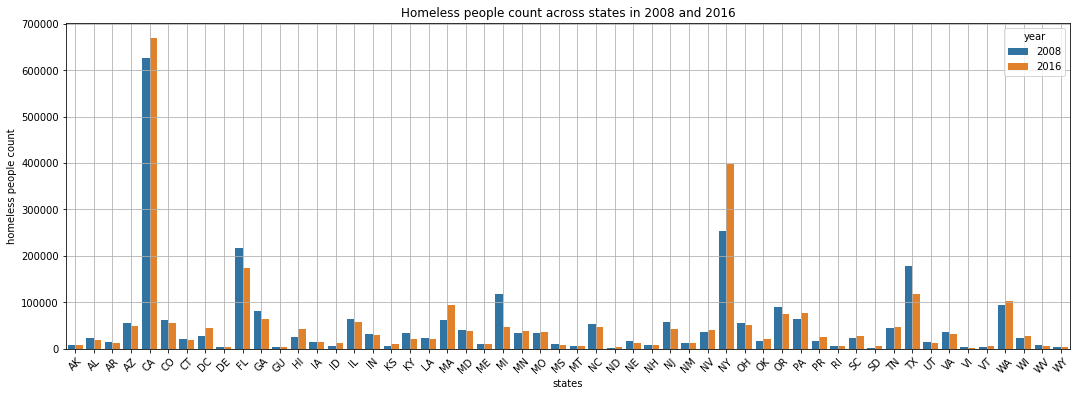

In [15]:
# set font
font = {'size'   : 16}
plt.rc('font', **font)

# plot the number of homeless people per state
plt.figure(figsize=(18,6))
sns.barplot(y='homeless_count', x='state_abbrev', hue="year", data=df_homeless_sub)
plt.ylabel('homeless people count')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Homeless people count across states in 2008 and 2016')
plt.grid()

Choropleth graph of homeless count by state

In [16]:
fig = px.choropleth(df_homeless_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

fig = px.choropleth(df_homeless_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='homeless_count',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Homeless Count by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

<a id='toc2_2_'></a>
## Housing data preprocess

[Return to contents](#contents)

Perform EDA analysis on the housing-related predictors. 

In [17]:
# Load the housing price dataset
df_housing = pd.read_csv("../data/State_time_series.csv")
df_housing.head()

,Date,RegionName,DaysOnZillow_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
0,1996-04-30,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45600.0,99500.0,79500.0,79000.0,140200.0,NaN,NaN,NaN,NaN,NaN
1,1996-04-30,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67100.0,78900.0,103600.0,107500.0,168700.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38400.0,70300.0,64400.0,64500.0,115200.0,NaN,NaN,NaN,NaN,NaN
3,1996-04-30,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95100.0,136100.0,157900.0,162000.0,270600.0,NaN,NaN,NaN,NaN,NaN
4,1996-04-30,Colorado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82700.0,99400.0,128100.0,133600.0,209300.0,NaN,NaN,NaN,NaN,NaN


In [18]:
# dictionary help to convert the state name to abbrevation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "WestVirginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "DistrictofColumbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}

In [19]:
# extract the year of the sold date and add a new column to the dataframe
df_housing['year'] = pd.DatetimeIndex(df_housing['Date']).year 

# subset the housing price data to 2008 and 2016
df_housing_sub = df_housing[df_housing['year'].isin([2008, 2016])]

# convert state full name to abbreviation
df_housing_sub["state_abbrev"] = df_housing_sub["RegionName"].map(us_state_to_abbrev)

df_housing_sub = df_housing_sub.groupby(["year","state_abbrev"])[["Sale_Prices", "MedianListingPricePerSqft_1Bedroom", "MedianListingPricePerSqft_2Bedroom", "MedianListingPricePerSqft_3Bedroom", "MedianListingPricePerSqft_4Bedroom", "MedianListingPricePerSqft_5BedroomOrMore"]].mean().reset_index()#.to_csv("Housing_data.csv", index=False)


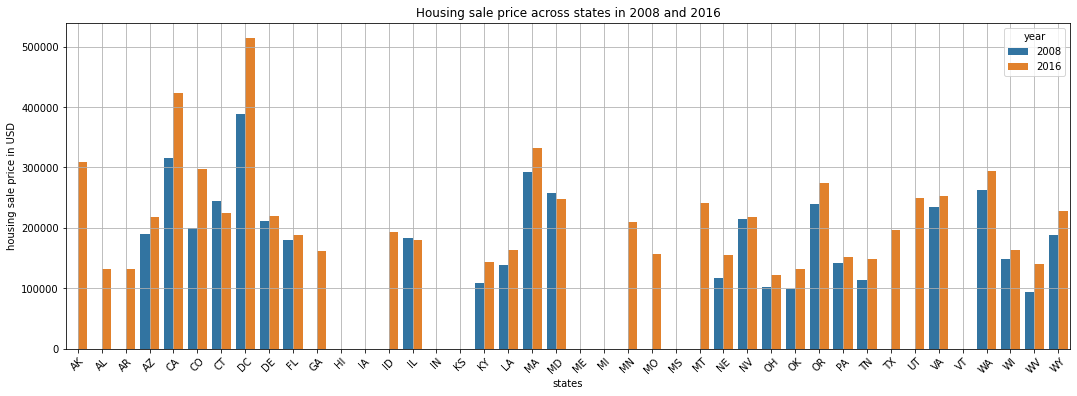

In [20]:
# plot the housing price per state
plt.figure(figsize=(18,6))
sns.barplot(y='Sale_Prices', x='state_abbrev', hue="year", data=df_housing_sub)
plt.ylabel('housing sale price in USD')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Housing sale price across states in 2008 and 2016')
plt.grid()

<a id='toc2_3_'></a>
## Political data preprocess

[Return to contents](#contents)

Perform EDA analysis on the political-related predictors. 

In [21]:
# Load the politics dataset
df_politics = pd.read_csv("../data/countypres_2000-2020.csv")
df_politics.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL


In [22]:
# subset the data to 2008 and 2016
df_politics_sub = (
df_politics.query("year == 2008 or year == 2016")
            .query("party == 'DEMOCRAT'")
            .rename(columns = {"state_po":"state_abbrev"})
            .groupby(["year", "state_abbrev"]).sum().reset_index()
)[['year', 'state_abbrev', 'candidatevotes', 'totalvotes']]


# calculate the percentage vote to democrat as a candidate predictor
df_politics_sub['democrat_perc'] = df_politics_sub['candidatevotes']/df_politics_sub['totalvotes'] * 100

df_politics_sub = df_politics_sub[['year', 'state_abbrev', 'democrat_perc']]
df_politics_sub.head()

,year,state_abbrev,democrat_perc
0,2008,AK,37.889374
1,2008,AL,38.740434
2,2008,AR,38.864660
3,2008,AZ,45.115251
4,2008,CA,61.012638


In [23]:
df_politics_sub

,year,state_abbrev,democrat_perc
0,2008,AK,37.889374
1,2008,AL,38.740434
2,2008,AR,38.864660
3,2008,AZ,45.115251
4,2008,CA,61.012638
...,...,...,...
97,2016,VT,56.675987
98,2016,WA,54.303577
99,2016,WI,46.436079
100,2016,WV,26.476928


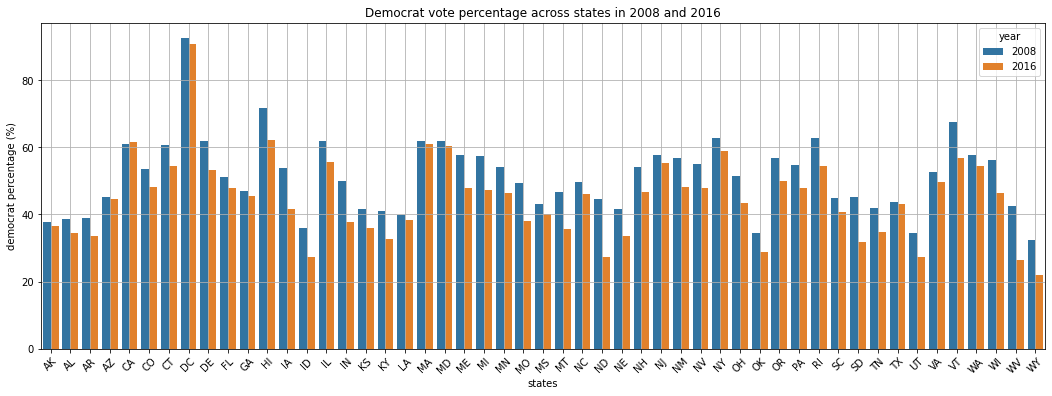

In [24]:
# plot the politics indicator per state
plt.figure(figsize=(18,6))
sns.barplot(y='democrat_perc', x='state_abbrev', hue="year", data=df_politics_sub)
plt.ylabel('democrat percentage (%)')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Democrat vote percentage across states in 2008 and 2016')
plt.grid()

In [25]:
df_politics_sub['win_party'] = df_politics_sub['democrat_perc'].apply(lambda x:"Democrat" if x>50 else "Republican")

In [26]:
color_scale = {'Republican': 'red', 'Democrat': 'blue'}


fig = px.choropleth(df_politics_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='win_party',
                    color_discrete_map=color_scale, 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()


color_scale = {'Republican': 'red', 'Democrat': 'blue'}


fig = px.choropleth(df_politics_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='win_party',
                    color_discrete_map=color_scale, 
                    )

fig.update_layout(
      title_text = 'Political Party by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

df_politics_sub.drop(columns=['win_party'])


,year,state_abbrev,democrat_perc
0,2008,AK,37.889374
1,2008,AL,38.740434
2,2008,AR,38.864660
3,2008,AZ,45.115251
4,2008,CA,61.012638
...,...,...,...
97,2016,VT,56.675987
98,2016,WA,54.303577
99,2016,WI,46.436079
100,2016,WV,26.476928


In [27]:
df_politics_sub = df_politics_sub.drop(columns=['win_party'])

<a id='toc2_4_'></a>
## Economic profile data preprocess

[Return to contents](#contents)

Perform EDA analysis on the economics-related predictors. 

In [28]:
df_econ = pd.read_csv("../data/profile_by_county_1969_2019.csv", encoding='latin-1')
df_econ

states_FIPS = ['01000', '02000', '03000', '04000', '05000', '06000', '07000', '08000', '09000']
for i in range(10, 57):
    fips = str(i)+'000'
    states_FIPS.append(fips)

df_econ['GeoFIPS'] = df_econ['GeoFIPS'].str.slice(2,7)

econ_cols = [' Per capita personal income 4/', ' Per capita net earnings 4/', 'Total employment (number of jobs)', ' Average wages and salaries']

In [30]:
df_econ_sub = (df_econ[['GeoFIPS', 'GeoName', 'Description', '2008', '2016']]
                 .query("GeoFIPS in @states_FIPS")
                 .query("Description in @econ_cols")
                 .assign(state_abbrev = df_econ['GeoName'].map(us_state_to_abbrev))
                 .drop(columns = ['GeoFIPS', 'GeoName'])               
                )

In [31]:
# subset data from 2008 and 2016
df_econ_sub_08 = (df_econ_sub.drop(columns = ['2016'])
                             .assign(year = 2008)
                 )
df_econ_sub_16 = (df_econ_sub.drop(columns = ['2008'])
                             .assign(year = 2016)
                 )

In [32]:
df_econ_sub_08 = (df_econ_sub_08.pivot_table(index=['year', 'state_abbrev'], columns='Description', values='2008', aggfunc='sum').reset_index()
                  .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )

df_econ_sub_16 = (df_econ_sub_16.pivot_table(index=['year', 'state_abbrev'], columns='Description', values='2016', aggfunc='sum').reset_index()
                  .rename(columns = {' Average wages and salaries':"AvgSalary", ' Per capita net earnings 4/':"PerCapNetEarning", ' Per capita personal income 4/':"PerCapNetIncome", "Total employment (number of jobs)":"TotalNumJobs"})
                 )


In [33]:
# combined table of economic data
df_econ_sub = pd.concat([df_econ_sub_08, df_econ_sub_16])
df_econ_sub.head()

Description,year,state_abbrev,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs
0,2008,AK,48527,31586,47749,443538
1,2008,AL,38138,20229,33353,2582591
2,2008,AR,35310,18526,31940,1579283
3,2008,AZ,43311,22318,35563,3402808
4,2008,CA,52524,28770,43890,20654292


In [34]:
# df_econ_sub.to_csv("../data/df_econ_sub001.csv", index=False)

In [35]:
# change column data type for following data preprocessing
df_econ_sub["AvgSalary"] = pd.to_numeric(df_econ_sub["AvgSalary"])
df_econ_sub["PerCapNetEarning"] = pd.to_numeric(df_econ_sub["PerCapNetEarning"])
df_econ_sub["PerCapNetIncome"] = pd.to_numeric(df_econ_sub["PerCapNetIncome"])
df_econ_sub["TotalNumJobs"] = pd.to_numeric(df_econ_sub["TotalNumJobs"])

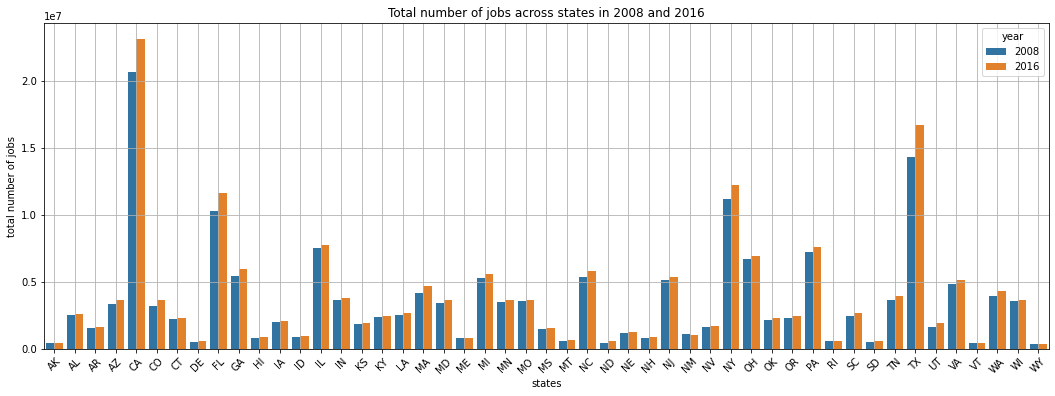

In [36]:
# plot the economics indicator per state
plt.figure(figsize=(18,6))
sns.barplot(y='TotalNumJobs', x='state_abbrev', hue="year", data=df_econ_sub)
plt.ylabel('total number of jobs')
plt.xlabel("states")
plt.xticks(rotation = 45)
plt.title('Total number of jobs across states in 2008 and 2016')
plt.grid()

In [37]:
# Choropleth graph of Total Number of Jobs by state
fig = px.choropleth(df_econ_sub.query("year == 2008"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2008',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

fig = px.choropleth(df_econ_sub.query("year == 2016"), 
                    locations='state_abbrev', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='TotalNumJobs',
                    color_continuous_scale="Viridis_r", 
                    )

fig.update_layout(
      title_text = 'Total Number of Jobs by State in 2016',
      title_font_size = 22,
      title_x=0.45, 
    )

fig.show()

<a id='toc2_5_'></a>
## Merge Datasets

[Return to contents](#contents)

In [42]:
df_combined = (df_homeless_sub.merge(df_politics_sub, how = "left", on = ['year', 'state_abbrev'])
                                  .merge(df_econ_sub, how = "left", on = ['year', 'state_abbrev'])
                                  .merge(df_housing_sub, how = "left", on = ['year', 'state_abbrev'])
                  )
df_combined.rename(columns={"state_abbrev": "state"},inplace=True)

df_combined.head()

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,AK,7462,37.889374,48527.0,31586.0,47749.0,443538.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,AL,23652,38.740434,38138.0,20229.0,33353.0,2582591.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,AR,14806,38.864660,35310.0,18526.0,31940.0,1579283.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,AZ,56146,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.0,NaN,NaN,NaN,NaN,NaN
4,2008,CA,626632,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.0,NaN,NaN,NaN,NaN,NaN


In [43]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 0 to 107
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   year                                      108 non-null    int64  
 1   state                                     108 non-null    object 
 2   homeless_count                            108 non-null    int64  
 3   democrat_perc                             102 non-null    float64
 4   AvgSalary                                 98 non-null     float64
 5   PerCapNetEarning                          98 non-null     float64
 6   PerCapNetIncome                           98 non-null     float64
 7   TotalNumJobs                              98 non-null     float64
 8   Sale_Prices                               58 non-null     float64
 9   MedianListingPricePerSqft_1Bedroom        38 non-null     float64
 10  MedianListingPricePerSqft_2Bedroom    

<a id='toc2_6_'></a>
## Missing Values

[Return to contents](#contents)

Check the data missingness across columns, plot the missingness.

year                                         0
state                                        0
homeless_count                               0
democrat_perc                                6
AvgSalary                                   10
PerCapNetEarning                            10
PerCapNetIncome                             10
TotalNumJobs                                10
Sale_Prices                                 50
MedianListingPricePerSqft_1Bedroom          70
MedianListingPricePerSqft_2Bedroom          66
MedianListingPricePerSqft_3Bedroom          66
MedianListingPricePerSqft_4Bedroom          66
MedianListingPricePerSqft_5BedroomOrMore    66
dtype: int64


<AxesSubplot: >

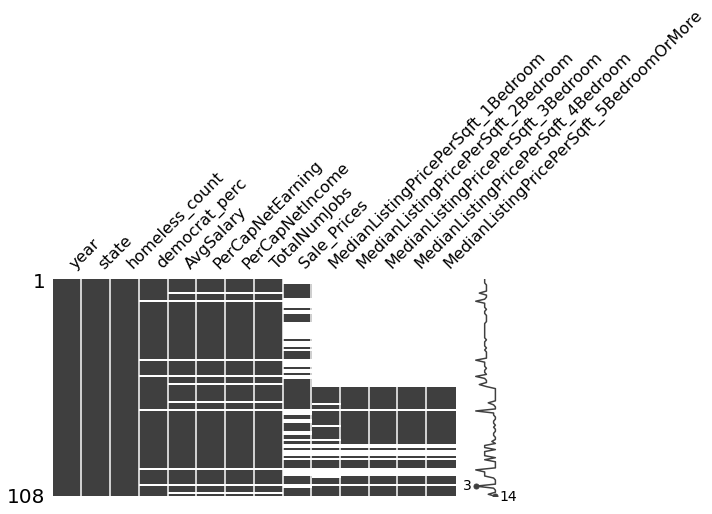

In [44]:
print(df_combined.isna().sum())

mn.matrix(df_combined,figsize=(8,4))

We have more data missing on the housing prices dataset, and less missingness on the politics data.

States such as Guam, American Samoa, Northern Mariana Islands, Puerto Rico, US Minor Outlying Islands, Virgin Islands have missing values. We hypothesized that the data were missing at random. 

<a id='toc2_7_'></a>

## Correlation between each variable and homeless count

[Return to contents](#contents)

In [45]:
df_combined.columns

Index(['year', 'state', 'homeless_count', 'democrat_perc', 'AvgSalary',
       'PerCapNetEarning', 'PerCapNetIncome', 'TotalNumJobs', 'Sale_Prices',
       'MedianListingPricePerSqft_1Bedroom',
       'MedianListingPricePerSqft_2Bedroom',
       'MedianListingPricePerSqft_3Bedroom',
       'MedianListingPricePerSqft_4Bedroom',
       'MedianListingPricePerSqft_5BedroomOrMore'],
      dtype='object')

<Figure size 1152x576 with 0 Axes>

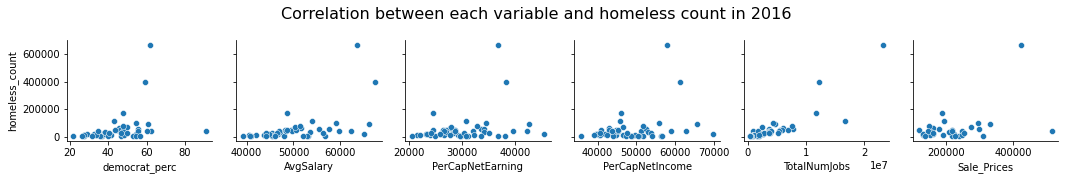

In [46]:
plt.figure(figsize=(16, 8))
g_16 = sns.pairplot(df_combined.query("year == 2016"), 
             x_vars=["democrat_perc","AvgSalary","PerCapNetEarning", "PerCapNetIncome", "TotalNumJobs", 'Sale_Prices'],
             y_vars=["homeless_count"])

g_16.fig.suptitle('Correlation between each variable and homeless count in 2016', fontsize = 16)
g_16.fig.tight_layout()

Text(0.5, 1.0, 'Correlation Heatmap for Housing predictors')

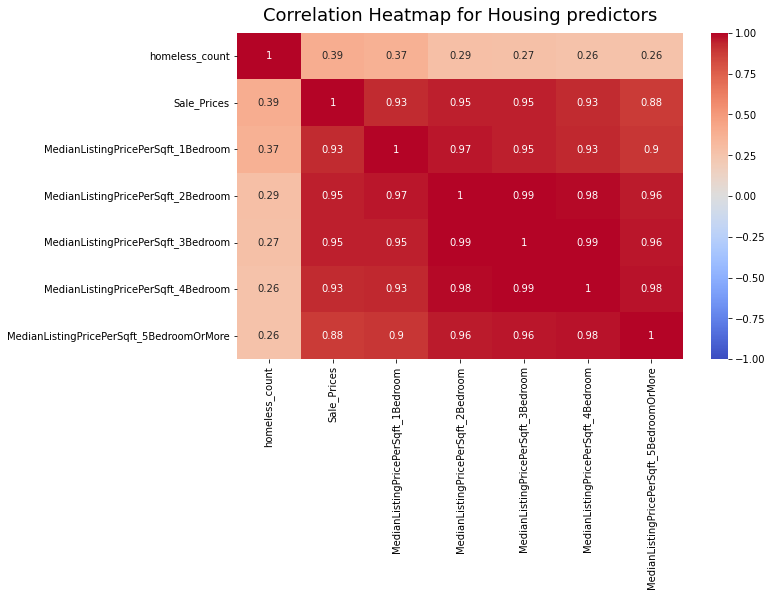

In [47]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(pd.merge(df_homeless_sub, df_housing_sub, how="left", left_on=["year", "state_abbrev"], right_on=["year", "state_abbrev"]).drop(columns = ['year']).corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Correlation Heatmap for Housing predictors', fontdict={'fontsize':18}, pad=12)

Text(0.5, 1.0, 'Correlation Heatmap for Economics and Politics Predictors')

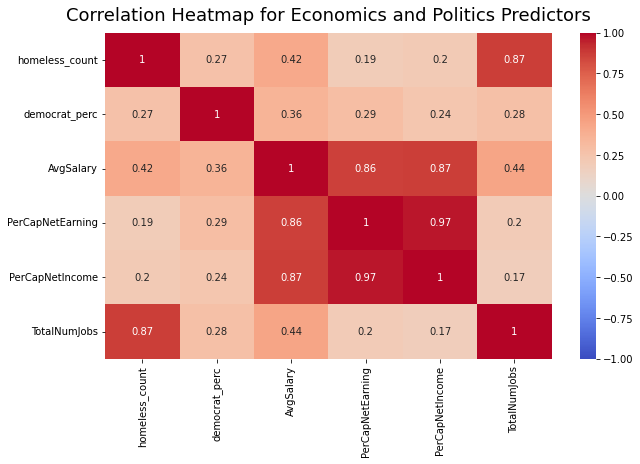

In [48]:
plt.figure(figsize=(10, 6))
heatmap_08 = sns.heatmap(df_combined[["homeless_count", "democrat_perc","AvgSalary","PerCapNetEarning", "PerCapNetIncome", "TotalNumJobs"]].corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap_08.set_title('Correlation Heatmap for Economics and Politics Predictors', fontdict={'fontsize':18}, pad=12)

<a id='toc2_8_'></a>

# Combined data preprocess

[Return to contents](#contents)

### Categorical variable preprocessing

In [52]:
# Categorical variables: state_abbrev (use one-hot encoding later)
enc = OrdinalEncoder()
# enc = OneHotEncoder(handle_unknown='ignore')
df_combined['state'] = enc.fit_transform(df_combined[['state']])

df_combined

,year,state,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008,0.0,7462,37.889374,48527.0,31586.0,47749.0,443538.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2008,1.0,23652,38.740434,38138.0,20229.0,33353.0,2582591.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2008,2.0,14806,38.864660,35310.0,18526.0,31940.0,1579283.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,3.0,56146,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,NaN,NaN,NaN,NaN,NaN
4,2008,4.0,626632,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016,49.0,5762,56.675987,44188.0,29569.0,50420.0,433924.0,NaN,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016,50.0,103862,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016,51.0,27656,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016,52.0,7020,26.476928,NaN,NaN,NaN,NaN,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


### Impute missing data

In [53]:
# kNN imputer
knn_imp = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(knn_imp.fit_transform(df_combined))
df_imputed.columns = df_combined.columns

# exclude the state
df_imputed = df_imputed.drop(columns = "state")
df_imputed

,year,homeless_count,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,2008.0,7462.0,37.889374,48527.0,31586.0,47749.0,443538.0,224453.000000,234.467850,211.465048,192.653812,196.214228,204.699495
1,2008.0,23652.0,38.740434,38138.0,20229.0,33353.0,2582591.0,255220.000000,230.072172,175.357543,162.210619,172.229239,188.423450
2,2008.0,14806.0,38.864660,35310.0,18526.0,31940.0,1579283.0,270416.000000,207.921037,174.354877,163.438545,173.466750,188.025318
3,2008.0,56146.0,45.115251,43311.0,22318.0,35563.0,3402808.0,190750.000000,176.217720,143.692009,138.184614,138.514814,137.950729
4,2008.0,626632.0,61.012638,52524.0,28770.0,43890.0,20654292.0,314980.000000,285.428588,232.267037,203.968278,208.494190,232.766133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2016.0,5762.0,56.675987,44188.0,29569.0,50420.0,433924.0,232239.000000,152.405230,146.871426,140.774273,138.816947,121.721618
104,2016.0,103862.0,54.303577,58989.0,34596.0,55802.0,4310119.0,294916.666667,270.179354,192.746052,174.273438,174.817988,183.988193
105,2016.0,27656.0,46.436079,46551.0,30320.0,47598.0,3658030.0,163283.333333,139.400275,119.647646,119.108371,113.191737,98.356697
106,2016.0,7020.0,26.476928,44756.4,29259.6,46229.0,1037707.6,140341.666667,111.100490,81.744695,90.590600,93.592909,89.201195


### Data standardization
Here we standardize our data for training different models by each member. 

In [54]:
scaler = StandardScaler()
df_imputed_scaled = scaler.fit_transform(df_imputed)
df_imputed_scaled = pd.DataFrame(df_imputed_scaled, columns=df_imputed.columns)
df_imputed_scaled
X_scaled = df_imputed_scaled.drop(columns='homeless_count')
y_scaled = df_imputed_scaled['homeless_count']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=300) # set seed for reproducibility

Save the data to ../data file. For the group project, we commented out the files to make it consistant.

In [55]:
# X_train.to_csv("../data/scaled_X_train.csv", index=False)
# X_test.to_csv("../data/scaled_X_test.csv", index=False)
# y_train.to_csv("../data/scaled_y_train.csv", index=False)
# y_test.to_csv("../data/scaled_y_test.csv", index=False)

<a id='toc3_'></a>

# Regression Modeling and Evaluation
[Return to contents](#contents)

<a id='toc3_1_'></a>

## 1. Baseline Model

[Return to contents](#contents)

In [56]:
# Read in data saved in previous EDA process
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


### 1.1 Build univariate baseline model

For the baseline model, we only select one predictor (Total Number of Jobs) to train a univariate linear model:

In [57]:
predictor = 'TotalNumJobs'
baseline_linreg = LinearRegression().fit(X_train[predictor].values.reshape(-1,1), y_train)

Use the baseline model to make prediction on both train and test data, then calculate its mean squared error and r-squared statistics of the baseline regression model:

In [58]:
#Predict
y_pred_train = baseline_linreg.predict(X_train[predictor].values.reshape(-1,1))
y_pred_test = baseline_linreg.predict(X_test[predictor].values.reshape(-1,1))

#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred_test)
base_train_r2 = r2_score(y_train, y_pred_train)
base_test_r2 = r2_score(y_test, y_pred_test)

print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{base_train_r2:.4f}")
print(f"\tTest R-squared\t{base_test_r2:.4f}")

Linear regression model results:

	Train MSE	0.1813
	Test MSE	0.4921

	Train R-squared	0.8312
	Test R-squared	0.2936


In [59]:
baseline_model_slope =baseline_linreg.coef_
baseline_model_intercept = baseline_linreg.intercept_

baseline_model_params = [baseline_linreg.intercept_, *baseline_linreg.coef_]
baseline_model_params_df = pd.DataFrame(baseline_model_params, columns = ["Coefficient"], index=["intercept"]+[str(i) for i in [predictor]])
baseline_model_params_df

,Coefficient
intercept,0.010981
TotalNumJobs,0.956447


### 1.2 Plot the baseline model

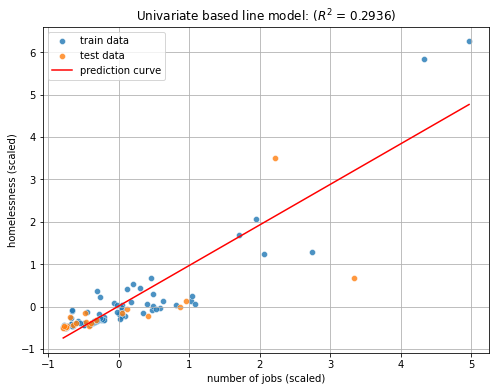

In [60]:
# Preliminary plotting
plt.figure(figsize=(8,6))
x_lin = np.linspace(min(X_train[predictor].values), max(X_train[predictor].values), 1000).reshape(-1, 1)

# split the x and y coords for plotting
pred_curve_y = [i*baseline_model_slope[0] + baseline_model_intercept for i in x_lin]

sns.scatterplot(x=X_train.TotalNumJobs.values,y=y_train.homeless_count.values,alpha=0.8, label="train data")
sns.scatterplot(x=X_test.TotalNumJobs.values,y=y_test.homeless_count.values,alpha=0.8, label="test data")
plt.plot(x_lin, pred_curve_y, label = f"prediction curve", c='red')
plt.title(f"Univariate based line model: ($R^2$ = {base_test_r2:.4f})")
plt.ylabel("homelessness (scaled)")
plt.xlabel("number of jobs (scaled)")
plt.legend()
plt.grid()

<a id='toc3_2_'></a>
## 2. Multivariate linear model
[Return to contents](#contents)

In [61]:
%matplotlib inline

In [62]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [63]:
# Read in data
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


### 2.1 Build Lasso model with CV

To find our baseline lasso model, we impleneted cross-validation to find the `best_alpha` that generates the best cross-validation MSE. We also recorded the mean cross-validation MSE across each fold.

In [64]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_cv = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_cv.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha_cv = lasso_cv.alpha_
best_alpha_cv

1e-06

Text(0.5, 1.0, 'Coefficient value')

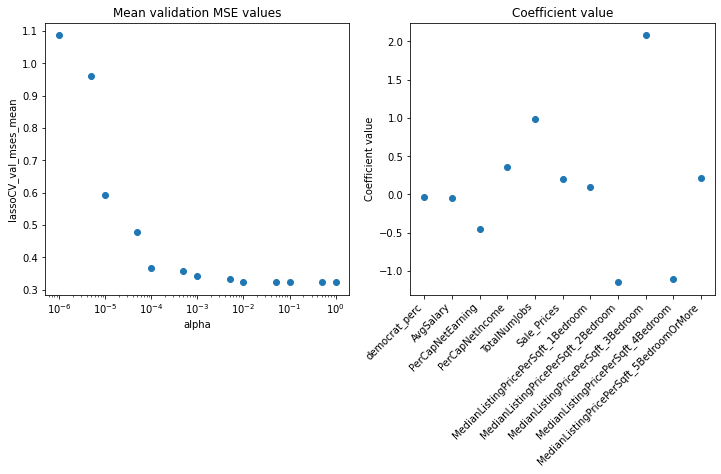

In [65]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_cv.coef_.shape[0],lasso_cv.coef_.shape[0]),lasso_cv.coef_)
axs[1].set_xticks(np.arange(1,lasso_cv.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [66]:
# Make predictions
y_train_predict = lasso_cv.predict(X_train)
y_test_predict = lasso_cv.predict(X_test)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

# print("The train MSE for the lasso model is " + str(train_mse))
# print("The test MSE for the lasso model is " + str(test_mse))

print("Lasso model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

# Modal diagnostics
train_score = lasso_cv.score(X_train,y_train)
test_score = lasso_cv.score(X_test,y_test)

# print("The train R2 for the lasso model is " + str(train_score))
# print("The test R2 for the lasso model is " + str(test_score))


print(f"\tTrain R-squared\t{train_score:.4f}")
print(f"\tTest R-squared\t{test_score:.4f}")

Lasso model results:

	Train MSE	0.1053
	Test MSE	0.3926

	Train R-squared	0.9020
	Test R-squared	0.4364


The train and test MSE is small, but the R-squared values for test and training set differ a lot (test R2 is much lower comparing to training R2). Therefore, it seems like the model overfitted.

### 2.2 Reduce overfitting of the lasso regression model

According to the EDA and the heatmap of the predictors, some predictors are highly correlated (especially the Zillow data set).

Therefore, in the following part, we try to minize the effect of such correlation using either `PCA` or `directly removing` some highly correlated variables.

### 2.3 Feature Selection for multivariate model

#### 2.3.1. PCA

By doing PCA of the original data, we could reduce the correlation between the predictor while keeping the original features of the variables. Here, we iterate through all possible component number of PCA, and select the best performing one based on mean validation MSE.

Within each iteration, we perform lasso cross-validation to find the best alpha of that iteration.

In [67]:
# Find the best k
val_mses_mean = []
val_r2_train = []
val_r2_test = []
k_list = [1,2,3,4,5,6,7,8,9,10,11]

for k in k_list:
    X_pca_train = PCA(n_components=k).fit_transform(X_train)
    X_pca_test = PCA(n_components=k).fit_transform(X_test)
    
    # Fit model
    lasso_pca = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_pca_train, y_train.values.ravel())
    # cv_results = cross_validate(linreg, X_pca_train, y_train_scaled, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    best_alpha_idx = find_nearest(a_list,lasso_pca.alpha_)[1]
    # print(find_nearest(a_list,lasso_pca.alpha_))
    val_mses_mean.append(lasso_pca.mse_path_[best_alpha_idx].mean())
    
    # Model diagnostics
    r2_train = lasso_pca.score(X_pca_train,y_train)
    r2_test = lasso_pca.score(X_pca_test,y_test)
    val_r2_train.append(r2_train)
    val_r2_test.append(r2_test)
    print("The train R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_train))
    print("The test R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_test))
    
best_k = k_list[val_mses_mean.index(min(val_mses_mean))]
print(f"The best k is {best_k}.")

The train R2 for current lasso_pca model (k = 1): 0.0
The test R2 for current lasso_pca model (k = 1): -0.024548181060703334
The train R2 for current lasso_pca model (k = 2): 0.15664460121824153
The test R2 for current lasso_pca model (k = 2): 0.37639750501467983
The train R2 for current lasso_pca model (k = 3): 0.7813649525044554
The test R2 for current lasso_pca model (k = 3): 0.3494316612125675
The train R2 for current lasso_pca model (k = 4): 0.8701652983101975
The test R2 for current lasso_pca model (k = 4): 0.18343512582861377
The train R2 for current lasso_pca model (k = 5): 0.8780285510471235
The test R2 for current lasso_pca model (k = 5): 0.18692597723079485
The train R2 for current lasso_pca model (k = 6): 0.8795452739480535
The test R2 for current lasso_pca model (k = 6): 0.1884168787260566
The train R2 for current lasso_pca model (k = 7): 0.883256862455392
The test R2 for current lasso_pca model (k = 7): 0.18152132941819266
The train R2 for current lasso_pca model (k = 8):

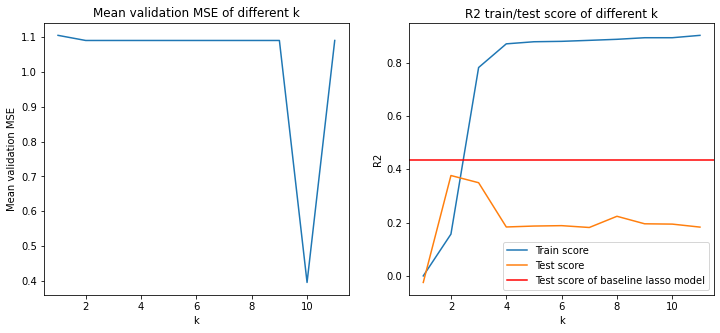

In [68]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(k_list,val_mses_mean,label='Mean validation MSE')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Mean validation MSE')
axs[0].set_title('Mean validation MSE of different k')


axs[1].plot(k_list,val_r2_train,label='Train score')
axs[1].plot(k_list,val_r2_test,label='Test score')
axs[1].axhline(test_score,color='r',label="Test score of baseline lasso model")
axs[1].set_xlabel('k')
axs[1].set_ylabel('R2')
axs[1].set_title('R2 train/test score of different k')
axs[1].legend()

All possible components have similar mean validation MSE except 10. However, even the highest test score achieved after PCA (k=2) is still way lower comparing to the baseline LassoCV model (red line). 

Next, we considered to drop those highly correlated variable.

#### 2.3.2 Drop the hightly correlated predictors

In [69]:
corr_matrix = X_train.corr()
high_corr = {}

high_corr_mat = corr_matrix[corr_matrix[abs(corr_matrix)>= 0.95].notna()]
for i in range(high_corr_mat.shape[0]):
    for j in range(high_corr_mat.shape[1]):
        if not np.isnan(high_corr_mat.iloc[i,j]) and i != j:
            if i >= j:
                new_pair = {(high_corr_mat.columns[i],high_corr_mat.columns[j]): high_corr_mat.iloc[i,j]}
            else: 
                new_pair = {(high_corr_mat.columns[j],high_corr_mat.columns[i]): high_corr_mat.iloc[i,j]}
            high_corr.update(new_pair)

            
print("The following pairs of predictor variables have correlation greater than 0.95 or less than -0.95:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.95 or less than -0.95:


{('PerCapNetIncome', 'PerCapNetEarning'): 0.9721387036981505,
 ('MedianListingPricePerSqft_2Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.971674690757072,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.955745751157604,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9953721459389778,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9873771771268126,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_2Bedroom'): 0.962154323671749,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_3Bedroom'): 0.9943276450364248,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_3Bedroom'): 0.9669431068424044,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_4Bedroom'): 0.9810106437907365}

In [70]:
# Drop variable
X_train_drop =  X_train.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_test_drop =  X_test.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_train_drop.head()

,democrat_perc,AvgSalary,PerCapNetEarning,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom
0,1.187014,1.023277,0.984646,0.178410,1.221901,-0.036893,0.021631,0.023977
1,1.199637,0.023937,-0.383640,-0.750147,-0.009682,0.080594,0.070108,-0.025834
2,-0.572699,-1.057257,-1.294860,-0.280227,-1.590602,-0.440902,-0.402933,-0.376713
3,0.833619,0.072848,0.041553,0.112448,0.760825,-0.353839,-0.324579,-0.287681
4,0.756480,-0.606384,-0.832131,-0.309058,0.428678,-0.444504,-0.301532,-0.277814


In [71]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_drop = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train_drop, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_drop.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha = lasso_drop.alpha_
best_alpha

1e-06

Text(0.5, 1.0, 'Coefficient value')

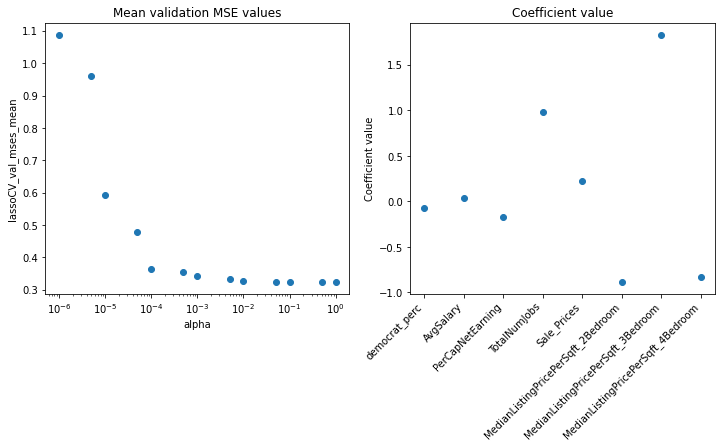

In [72]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_drop.coef_.shape[0],lasso_drop.coef_.shape[0]),lasso_drop.coef_)
axs[1].set_xticks(np.arange(1,lasso_drop.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train_drop.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [73]:
# Make predictions
y_train_predict = lasso_drop.predict(X_train_drop)
y_test_predict = lasso_drop.predict(X_test_drop)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

print("Predictor-adjusted lasso model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

# Modal diagnostics
train_score = lasso_drop.score(X_train_drop,y_train)
test_score = lasso_drop.score(X_test_drop,y_test)

print(f"\tTrain R-squared\t{train_score:.4f}")
print(f"\tTest R-squared\t{test_score:.4f}")

Predictor-adjusted lasso model results:

	Train MSE	0.1112
	Test MSE	0.4365

	Train R-squared	0.8965
	Test R-squared	0.3735


After dropping some variables, we losses some important information about the data, so the model performance is worse than the baseline LassoCV model. 

Therefore, we decided to keep the original LassoCV model with all the features as final model for the Multivariate linear regression.

### 2.4 Feature importance by coefficient value

Since both PCA and dropping variable do not improve the model performance, we retrain the best lassoCV model we found on the entire training set.

In [74]:
# Retrain with best alpha and using all the training set
lasso_best = Lasso(alpha=best_alpha_cv,max_iter=100000,random_state=26).fit(X_train,y_train)

# Make predictions
y_train_predict_best = lasso_best.predict(X_train)
y_test_predict_best = lasso_best.predict(X_test)
best_train_mse = mean_squared_error(y_train,y_train_predict_best)
best_test_mse = mean_squared_error(y_test,y_test_predict_best)

# Modal evaluation
best_train_score = lasso_best.score(X_train,y_train)
best_test_score = lasso_best.score(X_test,y_test)


print("Lasso multivariate regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        best_train_mse,
        best_test_mse,
    )
)

print(f"\tTrain R-squared\t{best_train_score:.4f}")
print(f"\tTest R-squared\t{best_test_score:.4f}")

Lasso multivariate regression model results:

	Train MSE	0.1053
	Test MSE	0.3926

	Train R-squared	0.9020
	Test R-squared	0.4364


Text(0.5, 1.0, 'Coefficient value')

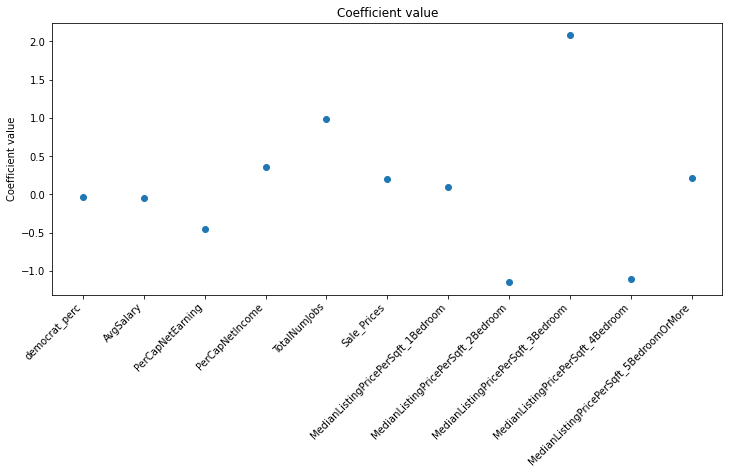

In [75]:
fig,axs = plt.subplots(1,1,figsize=(12, 5))

axs.scatter(np.linspace(1,lasso_best.coef_.shape[0],lasso_best.coef_.shape[0]),lasso_best.coef_)
axs.set_xticks(np.arange(1,lasso_best.coef_.shape[0]+1))
axs.set_xticklabels(X_train.columns, rotation=45, ha='right')
axs.set_ylabel('Coefficient value')
axs.set_title("Coefficient value")

As shown in plot above, while all variable have a non-zero coefficients, `TotalNumJobs`, `MedianListingPricePerSqft_1Bedroom`, `MedianListingPricePerSqft_2Bedroom`, `MedianListingPricePerSqft_4Bedroom`,`MedianListingPricePerSqft_3Bedroom`, have the largest absolute coefficient, suggesting they might be important for predicting homeless count.

However, since the `best_alpha` is small, none of the coefficients converges to zero. Moreover, while a test R2 score of LassoCV is higher comparing to our baseline model's test R2 score (~0.29), it is still insufficient to be considered as a good model. Therefore, we explore other options of more complex model, especially decision tree-based models like Bagging, AdaBoost, RandomForest, and XGBoost.

<a id='toc3_3_'></a>
## 3. RandomForest Regression model 
[Return to contents](#contents)

### 3.1 Build Random Forest Regression model

In [76]:
# train a randomForestRegressor model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# prediction
y_train_predict = rfr.predict(X_train)
y_test_predict = rfr.predict(X_test)


#Compute the MSE of the model
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)
randomForestRegressor_train_r2 = rfr.score(X_train, y_train)
randomForestRegressor_test_r2 = rfr.score(X_test, y_test)

print("Random Forest Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_r2:.4f}")

Random Forest Regressor results:

	Train MSE	0.0328
	Test MSE	0.3457

	Train R-squared	0.9695
	Test R-squared	0.5038


The train and test MSE is small, but the R-squared values differ a lot. Therefore, it seems like the model overfitted. Perform a GridSearchCV

### 3.2 Hyperparameter tuning with GridSearchCV

In [77]:
gsc_rfr = GridSearchCV(
        estimator=RandomForestRegressor(random_state=300),
        param_grid={
            "max_depth": range(1,7),
            'n_estimators': (1,10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result_rfr = gsc_rfr.fit(X_train, y_train.values.ravel())
best_params_rfr = grid_result_rfr.best_params_

grid_rfr = RandomForestRegressor(max_depth = best_params_rfr["max_depth"], n_estimators=best_params_rfr["n_estimators"], bootstrap=True, random_state=300, verbose=False)

grid_rfr.fit(X_train, y_train)

# prediction
y_train_GridCV_predict = grid_rfr.predict(X_train)
y_test_GridCV_predict = grid_rfr.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)
randomForestRegressor_train_GridCV_r2 = grid_rfr.score(X_train, y_train)
randomForestRegressor_test_GridCV_r2 = grid_rfr.score(X_test, y_test)

print("Random Forest Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{randomForestRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{randomForestRegressor_test_GridCV_r2:.4f}")

Random Forest Regressor Gridsearch results:

	Train MSE	0.0348
	Test MSE	0.1661

	Train R-squared	0.9676
	Test R-squared	0.7616


### 3.3 Feature importance by shap value

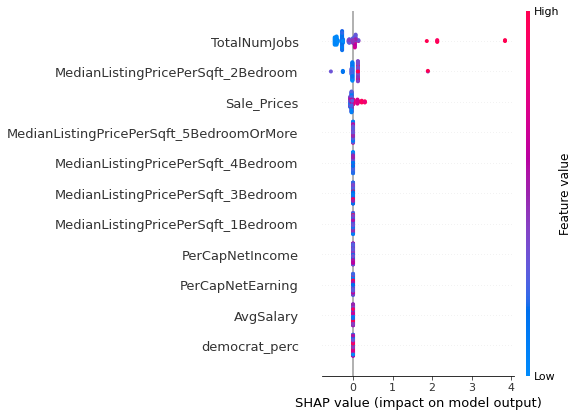

In [79]:
explainer_baggingRegressor = shap.TreeExplainer(grid_rfr)
shap_values = explainer_baggingRegressor.shap_values(X_train)

shap.summary_plot(shap_values, X_train, title="RandomForestRegressor Feature Importance (Train)")

<a id='toc3_4_'></a>
## 4. AdaBoost Regression Model 
[Return to contents](#contents)

AdaBoost stands for Adaptive Boosting, it is a ensemble algorithm that create a combination model by improving the weights of the weak learners. AdaBoost can be used as a regression model for homeless prediction. 

### 4.1 Build a AdaBoost Regression Model

First, we start by training a baseline AdaBoost Regressor without hyperparameter tuning:

In [80]:
# initialize adaboost regressor
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), learning_rate=1.0, loss='linear',
         n_estimators=1000, random_state=300) 

# fit the model with training data
ada_model.fit(X_train, y_train)

# train and test prediction 
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

ada_train_r2 = ada_model.score(X_train, y_train)
ada_test_r2 = ada_model.score(X_test, y_test)

print("AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{ada_train_r2:.4f}")
print(f"\tTest R-squared\t{ada_test_r2:.4f}")

AdaBoost Regressor results:

	Train MSE	0.0200
	Test MSE	0.2352

	Train R-squared	0.9814
	Test R-squared	0.6624


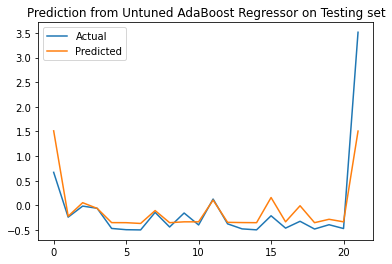

In [81]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned AdaBoost Regressor on Testing set")
plt.legend()
plt.show()

The performance is already better than the univariate model and multivariate-lasso regression model. The R-squared showed that the AdaBoost Model might be overfitting. 

So we decided to use `Hypopt` to tune the hyperparamaters of the AdaBoost Regression model efficiently:

### 4.2 Hyperparameter tuning with Hypopt

In [82]:
# !!! This code cell takes about 2mins to run
# Search space for hyperparameter tuning
space = {
        'random_state': 300,
        "base_estimator": hp.choice("base_estimator", [DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4)]),
        'n_estimators':hp.choice('n_estimators', np.arange(1, 200, 1, dtype=int)),
        "learning_rate": hp.choice('learning_rate', [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
        'loss': hp.choice('loss', ['linear', 'square', 'exponential'])
        }

hypopt_scores = []

def score(params):
    model = AdaBoostRegressor(**params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


100%|██████████| 1000/1000 [01:09<00:00, 14.41trial/s, best loss: 0.39046273752964195]


{'base_estimator': DecisionTreeRegressor(max_depth=4),
 'learning_rate': 0.01,
 'loss': 'exponential',
 'n_estimators': 15,
 'random_state': 300}

Fit the best model with the selected hyperparameters.

(note: The best parameter set of each search run varies, so we used the result of one of the best parameter sets to make the result consistent.)

In [83]:
best_params = {'base_estimator': DecisionTreeRegressor(max_depth=3),
                'learning_rate': 0.0001,
                'loss': 'exponential',
                'n_estimators': 50,
                'random_state': 300}

best_adamodel = AdaBoostRegressor(**best_params)
best_adamodel.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.0001, loss='exponential', random_state=300)

Make model prediction using the tuned model with the best performance:

In [84]:
# prediction
y_train_pred_best = best_adamodel.predict(X_train)
y_test_pred_best = best_adamodel.predict(X_test)

# calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_adamodel.score(X_train, y_train)
test_r2_best = best_adamodel.score(X_test, y_test)

print("Hyperparameter Tuned AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

Hyperparameter Tuned AdaBoost Regressor results:

	Train MSE	0.0288
	Test MSE	0.1512

	Train R-squared	0.9732
	Test R-squared	0.7830


After tuning the parameters of the AdaBoost Regressor, it outperforms linear regression models and is also slightly better than the Random forest regerssor because it learned to adjust the weights of the weak learners.

### 4.3 Feature Importance of AdaBoost Regression Model

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

Text(0.5, 1.0, 'AdaBoost Regressor feature importance')

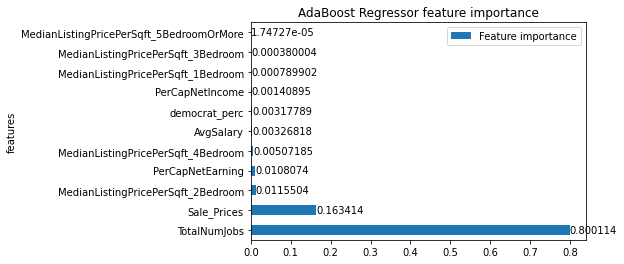

In [85]:
feature_importances_plot = list(zip(list(X_train.columns), best_adamodel.feature_importances_))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("AdaBoost Regressor feature importance")

<a id='toc3_5_'></a>
## 5. Bagging Regression model   
[Return to contents](#contents)

### 5.1 Build a Bagging Regression Model

In [86]:
bagging_ensemble = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators=1, 
                                    max_features=1.0, bootstrap_features=False, random_state=300).fit(X_train, y_train)


# prediction
y_train_bagging_predict = bagging_ensemble.predict(X_train)
y_test_bagging_predict = bagging_ensemble.predict(X_test)


#Compute the MSE of the model
bagging_train_mse = mean_squared_error(y_train,y_train_bagging_predict)
bagging_test_mse = mean_squared_error(y_test,y_test_bagging_predict)
bagging_ensemble_train_GridCV_r2 = bagging_ensemble.score(X_train, y_train)
bagging_ensemble_test_GridCV_r2 = bagging_ensemble.score(X_test, y_test)

print("Bagging Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        bagging_train_mse,
        bagging_test_mse,
    )
)

print(f"\tTrain R-squared\t{bagging_ensemble_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{bagging_ensemble_test_GridCV_r2:.4f}")

Bagging Regressor results:

	Train MSE	0.0219
	Test MSE	0.1940

	Train R-squared	0.9796
	Test R-squared	0.7215


### 5.2 Hyperparameter tuning with GridSearchCV
Perform a GridSearchCV to better turn the model

In [87]:
gsc_br = GridSearchCV(
        estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=300), random_state=300),
        param_grid={
            "base_estimator__max_depth": range(1,20),
            'n_estimators': (1,10, 50, 100, 1000)
        },
        cv=10, scoring='neg_mean_squared_error', n_jobs=-1)


grid_result_br = gsc_br.fit(X_train, y_train.values.ravel())
best_params_br = grid_result_br.best_params_

grid_bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=best_params_br["base_estimator__max_depth"], random_state=300),
                                n_estimators=best_params_br["n_estimators"], random_state=300)

grid_bagging.fit(X_train, y_train.values.ravel())

# prediction
y_train_GridCV_predict = grid_bagging.predict(X_train)
y_test_GridCV_predict = grid_bagging.predict(X_test)


#Compute the MSE of the model
train_GridCV_mse = mean_squared_error(y_train,y_train_GridCV_predict)
test_GridCV_mse = mean_squared_error(y_test,y_test_GridCV_predict)

baggingRegressor_train_GridCV_r2 = grid_bagging.score(X_train, y_train)
baggingRegressor_test_GridCV_r2 = grid_bagging.score(X_test, y_test)

print("Bagging Regressor Gridsearch results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_GridCV_mse,
        test_GridCV_mse,
    )
)

print(f"\tTrain R-squared\t{baggingRegressor_train_GridCV_r2:.4f}")
print(f"\tTest R-squared\t{baggingRegressor_test_GridCV_r2:.4f}")

Bagging Regressor Gridsearch results:

	Train MSE	0.0181
	Test MSE	0.1311

	Train R-squared	0.9831
	Test R-squared	0.8119


### 5.3 Feature importance of bagging regressor

Since the BaggingRegressor used with many base estimators, and shap library does not support the baggingRegressor, so we need to extract the feature_importances_ ourselves. 

Text(0.5, 1.0, 'BaggingRegressor feature importance')

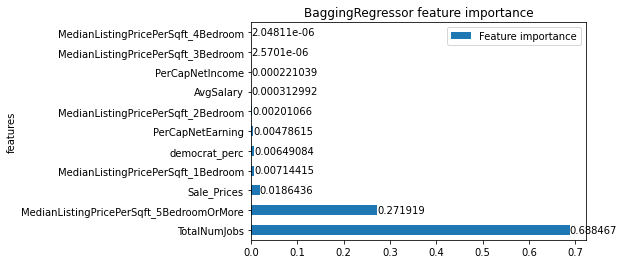

In [88]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in grid_bagging.estimators_
], axis=0)
feature_importances

feature_importances_plot = list(zip(list(X_train.columns), feature_importances))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("BaggingRegressor feature importance")

<a id='toc3_6_'></a>
## 6. XGBRegressor model
[Return to contents](#contents)

### 6.1 Build a XGBRegressor

In [89]:
# XGBoost Without Hyperparameter Tuning
params = {'random_state': 42,
            'colsample_bytree': 0.5,
             'eta': 0.3,
             'eval_metric': 'rmse',
             'max_depth': 5,
             'min_child_weight': 10,
             'n_estimators': 500,
             'objective': 'reg:squarederror',
             'subsample': 0.8}

xg_model = XGBRegressor(**params)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [90]:
# prediction
y_train_pred = xg_model.predict(X_train)
y_test_pred = xg_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = xg_model.score(X_train, y_train)
test_r2 = xg_model.score(X_test, y_test)

print("XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{train_r2:.4f}")
print(f"\tTest R-squared\t{test_r2:.4f}")

XGBoost Regressor results:

	Train MSE	0.0001
	Test MSE	0.4171

	Train R-squared	0.9999
	Test R-squared	0.4013


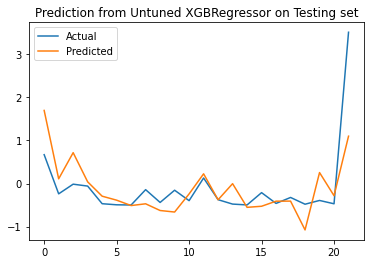

In [91]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned XGBRegressor on Testing set")
plt.legend()
plt.show()

### 6.2 Hyperparameter tuning with Hypopt

In [92]:
# !!! This code cell takes about 10mins to run
warnings.filterwarnings('ignore')

# space for hyperparameter tuning
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 20, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(10, 1000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.1, 0.3, 0.1),
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
        }

hypopt_scores = []

def score(params):
    model = XGBRegressor(**params)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


100%|██████████| 1000/1000 [05:22<00:00,  3.10trial/s, best loss: 0.22976672041155516]


{'colsample_bytree': 0.8,
 'eta': 0.30000000000000004,
 'eval_metric': 'rmse',
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 610,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [93]:
# fit the model with the best hyperparameters
best_params = {'random_state': 42,
               'colsample_bytree': 0.8,
                 'eta': 0.30000000000000004,
                 'eval_metric': 'rmse',
                 'max_depth': 3,
                 'min_child_weight': 4,
                 'n_estimators': 540,
                 'objective': 'reg:squarederror',
                 'subsample': 0.9}

best_xgmodel = XGBRegressor(**best_params)
best_xgmodel.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.30000000000000004, eval_metric='rmse', feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=540, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [94]:
# prediction
y_train_pred_best = best_xgmodel.predict(X_train)
y_test_pred_best = best_xgmodel.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_xgmodel.score(X_train, y_train)
test_r2_best = best_xgmodel.score(X_test, y_test)

print("Hyperparameter Tuned XGBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

Hyperparameter Tuned XGBoost Regressor results:

	Train MSE	0.0000
	Test MSE	0.1363

	Train R-squared	1.0000
	Test R-squared	0.8043


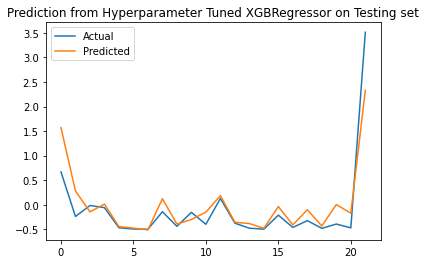

In [95]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred_best, label="Predicted")
plt.title("Prediction from Hyperparameter Tuned XGBRegressor on Testing set")
plt.legend()
plt.show()


### 6.3 Feature importance of XGB regressor

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

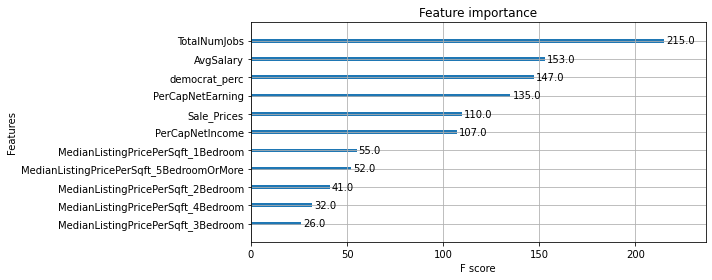

In [96]:
fig, ax = plt.subplots(figsize = (10, 4))
xgb.plot_importance(best_xgmodel, importance_type='weight', ax = ax)
plt.tight_layout()